In [1]:
!pip3 install pandas
!pip3 install spacy
!pip3 install numpy
!pip3 install scikit-learn
!pip3 install tensorflow
!pip3 install sklearn
!pip3 install transformers
!pip3 install wordcloud


In [2]:

import pandas as pd
import json
import numpy as np

import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
import seaborn as sns
from sklearn.model_selection import GridSearchCV


#BERT
import transformers
import tensorflow as tf
import tensorflow_hub as hub
from sklearn import preprocessing

2023-01-09 18:42:40.302907: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-09 18:42:40.303032: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Read and Pre-process the data
We read in the csv file.

In [3]:
df = pd.read_csv('/kaggle/input/fake-news-classification/WELFake_Dataset.csv')
df = df.drop(df.columns[[0]], axis=1) 
df

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


We drop rows without text and NaN

In [4]:

#Drop columns with NaN and empty string
df.dropna(subset=['title'], inplace=True)
df['text'].replace(' ', np.nan, inplace=True)
df.dropna(subset=['text'], inplace=True)
df.head(10)


,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1
6,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,DR. BEN CARSON TELLS THE STORY OF WHAT HAPPENE...,1
8,Sports Bar Owner Bans NFL Games…Will Show Only...,"The owner of the Ringling Bar, located south o...",1
9,Latest Pipeline Leak Underscores Dangers Of Da...,"FILE – In this Sept. 15, 2005 file photo, the ...",1
10,GOP Senator Just Smacked Down The Most Puncha...,The most punchable Alt-Right Nazi on the inter...,1
11,"May Brexit offer would hurt, cost EU citizens ...",BRUSSELS (Reuters) - British Prime Minister Th...,0


We use a bar chart to see how many fake and true news there are in the dataset

<AxesSubplot:>

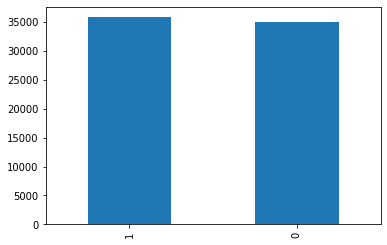

In [5]:
df.label.value_counts()
df.label.value_counts()[:2].plot(kind='bar')

Great! A pretty even distributed dataset

### lowercase and concat title and text

In [6]:
df['title'] = df['title'].apply(lambda title: str(title).lower())
df['text'] = df['text'].apply(lambda text: str(text).lower())

df['title_and_text'] = df[["title", "text"]].apply(" ".join, axis=1)
#print(df.head().title[0])
#print(df.head().text[0])
print(len(df.head().title_and_text[0]))
print(df.head().title_and_text[0])

5180
law enforcement on high alert following threats against cops and whites on 9-11by #blacklivesmatter and #fyf911 terrorists [video] no comment is expected from barack obama members of the #fyf911 or #fukyoflag and #blacklivesmatter movements called for the lynching and hanging of white people and cops. they encouraged others on a radio show tuesday night to  turn the tide  and kill white people and cops to send a message about the killing of black people in america.one of the f***yoflag organizers is called  sunshine.  she has a radio blog show hosted from texas called,  sunshine s f***ing opinion radio show. a snapshot of her #fyf911 @lolatwhitefear twitter page at 9:53 p.m. shows that she was urging supporters to  call now!! #fyf911 tonight we continue to dismantle the illusion of white below is a snapshot twitter radio call invite   #fyf911the radio show aired at 10:00 p.m. eastern standard time.during the show, callers clearly call for  lynching  and  killing  of white people.a

We can already see here that there will be some words that the models will be confused about, such as censored curse words, [] tags and # within the text.

## A smaller set to test
I created a smaller set to test the data on, in the end, the big dataset should be run to evaluate performance

In [7]:
#data = df.head(1000)

## Tokenize the dataset
To tokenize the dataset, huggingface DistilBertTokenizer will be used.
We only need to tokenize the text and not the labels because they are already binary


In [8]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Split the dataset into train and test. 20% should be test

In [9]:
X_train,X_test ,y_train,y_test = train_test_split(df['title_and_text'], df['label'], stratify=df['label'], test_size = 0.2)

In [10]:
X_train

68346    obama: u.s., southeast asia can advance 'share...
12168    meme magic: donald trump is the internet’s rev...
39785    юнисеф: в результате атаки на школу в идлибе п...
5369     real disclosure! secret alien base found in mo...
64723    a new paradigm for diagnosis and treatment of ...
                               ...                        
32227     trump’s buddy putin once said he could destro...
51764    syrian rebels resist jordan pressure to hand o...
44356     busted: trump supporter used poll watcher cre...
56658    irs identifies more cyberattacks to access tax...
26791    russia media group that angered kremlin is sol...
Name: title_and_text, Length: 56639, dtype: object

In [11]:
df['num_words'] = df['text'].apply(lambda x: len(x.split()))

To evaluate how many words there are in each row we plot is using sns. Code from https://www.kaggle.com/code/tmishinev/fake-news-keras-bert

Text(0.5, 1.0, 'Distribution of the News Words count')

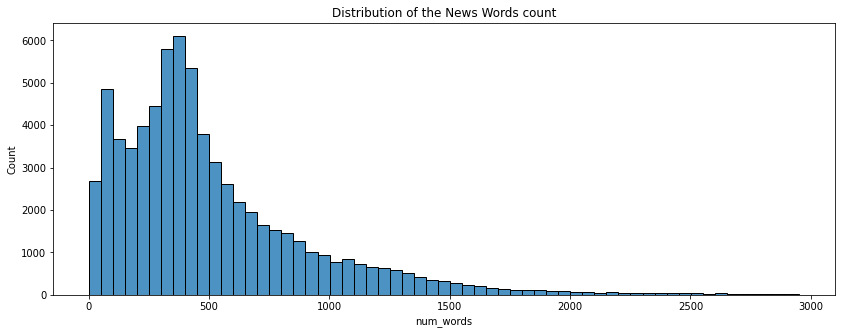

In [12]:
plt.figure(figsize = (14,5))
sns.histplot(df['num_words'], bins = range(1, 3000, 50), palette = 'Set1', alpha = 0.8)
plt.title('Distribution of the News Words count')

Using the DistilBERT tokenizer we batch_encode the text, we also convert it as a tensorflow list so it can be parsed into the model later.


The labels are also converted into small one-hot vectors to represent the truth and false values

In [13]:
X_train_encoded = tokenizer.batch_encode_plus(X_train, return_token_type_ids=False, return_attention_mask=False,
        max_length=450, return_tensors = 'tf', padding=True, truncation=True)

X_test_encoded = tokenizer.batch_encode_plus(X_test, return_token_type_ids=False, return_attention_mask=False,
        max_length=450, return_tensors = 'tf', padding=True, truncation=True)

y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=2,dtype = 'int32')
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=2,dtype = 'int32')

2023-01-09 19:03:29.102478: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-09 19:03:29.106742: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-09 19:03:29.106805: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-09 19:03:29.106834: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a1ebb181115a): /proc/driver/nvidia/version does not exist
2023-01-09 19:03:29.110931: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [14]:
X_train_encoded = np.array(X_train_encoded['input_ids'])
X_test_encoded = np.array(X_test_encoded['input_ids'])

In [15]:
X_train_encoded[0]

array([  101,  8112,  1024,  1057,  1012,  1055,  1012,  1010,  4643,
        4021,  2064,  5083,  1005,  4207,  4432,  1005,  2006,  7803,
       11936, 18123, 21483,  1010, 10250, 10128,  1012,  1006, 26665,
        1007,  1011,  2343, 13857,  8112,  2056,  2006,  6928,  2008,
        1996,  2142,  2163,  1998,  4643,  4004,  3741,  2064,  5083,
        1037,  4207,  4432,  1997,  3513,  1998, 17606,  2005, 29304,
        7803, 11936, 21614,  1012,  8112,  2081,  1996,  4431,  2000,
        1996,  2148,  2859,  2712,  1010,  2073,  2859,  1998,  2195,
        4643,  4004,  2163,  2031, 19326,  1998, 20567,  4447,  1010,
        2012,  1996,  2927,  1997,  1037,  6465,  2007,  4177,  1997,
        1996,  2523,  1997,  4643,  4004,  3741,  1006, 27974,  1007,
        1012,   102,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [16]:
y_train_encoded

array([[1, 0],
       [1, 0],
       [0, 1],
       ...,
       [0, 1],
       [1, 0],
       [1, 0]], dtype=int32)

## Using a dummy classifer as basline
To know how good the other models are, a stratified dummy classifer is used to evaluate the performance

In [17]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
dummy_prediction = dummy_clf.predict(X_train)

print(classification_report(y_train ,dummy_prediction))

              precision    recall  f1-score   support

           0       0.49      0.49      0.49     28022
           1       0.50      0.50      0.50     28617

    accuracy                           0.50     56639
   macro avg       0.50      0.50      0.50     56639
weighted avg       0.50      0.50      0.50     56639



Becuase we only have true or false. This accuracy is to be expected

In [18]:
X_train_encoded

array([[  101,  8112,  1024, ...,     0,     0,     0],
       [  101,  2033,  4168, ...,  1010,  2040,   102],
       [  101,  1209, 18947, ..., 14150, 29741,   102],
       ...,
       [  101, 23142,  1024, ...,  2005,  8398,   102],
       [  101, 25760, 14847, ...,     0,     0,     0],
       [  101,  3607,  2865, ...,  7615,  2006,   102]], dtype=int32)

## Logistic regression

In [19]:
pipe = Pipeline([('countVec', CountVectorizer(binary = True, ngram_range=(1,1))), ('logisticReg', LogisticRegression(max_iter=800, penalty='l2'))])
pipe.fit(X_train, y_train)
prediction_LR = pipe.predict(X_test)
print(classification_report(y_test ,prediction_LR))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7005
           1       0.96      0.98      0.97      7155

    accuracy                           0.97     14160
   macro avg       0.97      0.97      0.97     14160
weighted avg       0.97      0.97      0.97     14160



### Fine-tuning logistic regression the model using GirdSearchCV
This was used beforehand to validate the best performance of logistic regression. Best fit was {'countVec__binary': True, 'countVec__ngram_range': (1, 1), 'logisticReg__penalty': 'l2'}.
You can run it yourself to validate the best performance


In [20]:
"""
parameters = {
    'countVec__binary':[True, False], 
    'countVec__ngram_range':[(1,1), (1,2)], 
    'logisticReg__penalty': ('l1', 'l2', 'elasticnet'),
    'logisticReg__l1_ratio': (0.5,0.1,0.01)
    }

clf  = GridSearchCV(pipe, parameters, cv=5)
clf.fit(X_train, y_train) 
print(clf.best_params_) 
"""

"\nparameters = {\n    'countVec__binary':[True, False], \n    'countVec__ngram_range':[(1,1), (1,2)], \n    'logisticReg__penalty': ('l1', 'l2', 'elasticnet'),\n    'logisticReg__l1_ratio': (0.5,0.1,0.01)\n    }\n\nclf  = GridSearchCV(pipe, parameters, cv=5)\nclf.fit(X_train, y_train) \nprint(clf.best_params_) \n"

Lets see the false negatives and false positives

In [21]:
result_LR_df = pd.DataFrame({'text':X_test,'Correct_news':y_test, 'Predicted_news':prediction_LR})

In [22]:
df_LR_fn = result_LR_df[(result_LR_df['Correct_news'] == 0) & (result_LR_df['Predicted_news'] == 1)]
df_LR_fp = result_LR_df[(result_LR_df['Correct_news'] == 1) & (result_LR_df['Predicted_news'] == 0)]

In [23]:
df_LR_fn.head(10)

,text,Correct_news,Predicted_news
15465,exclusive: japan to delay multi-billion dollar...,0,1
46043,letter of recommendation: the useless machine ...,0,1
68993,hillary’s no slam dunk in 2016 could hillary c...,0,1
66932,mr. trump goes to washington: the surreal spec...,0,1
68000,the hunger in our heads - the new york times a...,0,1
43913,why rachel dolezal's assertion that she is bla...,0,1
15090,will nancy pelosi miss john boehner? depends. ...,0,1
66703,anti-trump women marchers threaten to never le...,0,1
15528,four illegal aliens arrested after ’savage’ ga...,0,1
11069,"as his campaign crumbles, trump is spending hi...",0,1


In [24]:
if not df_LR_fn.empty:
    print(df_LR_fn.text.iloc[0])

exclusive: japan to delay multi-billion dollar fighter jet development - sources tokyo (reuters) - japan will delay a decision to develop a new advanced fighter jet, four sources said, as military planners struggle to settle on a design and officials splash out on new u.s. equipment such as ballistic missile interceptors and f-35 stealth planes. faced with a growing military threat from north korea and increased activity by chinese air force jets over the east china sea, japan is under pressure to improve its defenses on two fronts. any delay to the new fighter, known as the f-3, will raise a question mark over the future of what could be one of the world s most lucrative upcoming military contracts, estimated at more than $40 billion to develop and deploy.  a decision after the first half of 2018 would be too late for it to be included as a core program in a new five-year defense equipment plan beginning april 2019 that japan will reveal at the end of next year.        the direction i

Creating a wordcloud of the most used words in the false negative

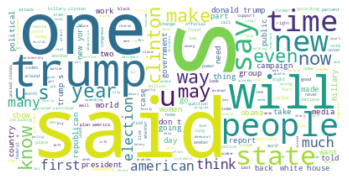

In [25]:
text = " ".join(text for text in df_LR_fn.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [26]:
df_LR_fp.head(10)

,text,Correct_news,Predicted_news
66584,ford’s new ceo snubs president trump…will buil...,1,0
11186,world’s first zero-emissions hydrogen-powered ...,1,0
22573,"walling them out, or walling us in? walling th...",1,0
66756,"jeb bush receives worst endorsement ever, def...",1,0
1882,obama inciting a second cold war? 35 russian d...,1,0
41682,"yes, obama can appoint a supreme court justice...",1,0
38688,trump’s economic program set for rough reality...,1,0
24378,is fox about to become cnn? leftist wives of l...,1,0
38404,comment on phallic art stuns residents of new ...,1,0
3277,john kerry's remarks at the chicago council on...,1,0


In [27]:
if not df_LR_fp.empty:
    print(df_LR_fp.text.iloc[0])

ford’s new ceo snubs president trump…will build focus in china…export to u.s. ford will export the next-generation focus compact car from china to north america in 2019, rather than from mexico as earlier planned, saving the company $500 million, a top executive said on tuesday.it is the first major manufacturing investment decision made by new chief executive officer jim hackett, who succeeded mark fields in late may.discussion about the small-car production shift from mexico to china began  a couple months ago  under fields, said joe hinrichs, president of global operations.in january, after u.s. president donald trump criticized ford for shipping small-car manufacturing to mexico, ford said it would kill plans to build a $1.8-billion focus plant in san luis potosi and instead produce the new focus at an existing plant in hermosillo.although it is cheaper to build and ship cars to the united states from mexico than china,  this was not a variable cost decision,  hinrichs said in a tu

## DISTILBERT

If we want to use Kaggles TPU, we enable it here

In [28]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2023-01-09 19:10:01.111721: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-09 19:10:01.149802: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2023-01-09 19:10:01.149877: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2023-01-09 19:10:01.171398: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2023-01-09 19:10:01.171457: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2023-01-09 19:10:01.173623: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:411] Started server with target: grpc://localhost:30019


REPLICAS:  8


From here, the model and intization of TPU were inspired by https://www.kaggle.com/code/foolofatook/news-classification-using-bert/notebook.
I have tweaked the model to perform better with binary labels instead of a vast amount of categories.


In [29]:
def build_bert_model(transformer,length):
    input_ids = tf.keras.layers.Input(shape=(length,), dtype=tf.int32, name="input_ids")
    embedding = transformer(input_ids)[0]
    cls_token = embedding[:, 0, :]
    dropout = tf.keras.layers.Dropout(0.1)(cls_token)
    y = tf.keras.layers.Dense(2, activation='sigmoid')(dropout)
    model = tf.keras.Model(inputs=input_ids, outputs=y)
    model.compile(tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon = 1e-7), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    return model

If using kaggle TPU 
From huggingface, we import the Automodel of DistilBERT

In [30]:
with strategy.scope():
    transformerModel = transformers.TFAutoModel.from_pretrained('distilbert-base-uncased')
    model = build_bert_model(transformerModel,450)


Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

2023-01-09 19:10:22.621434: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the 

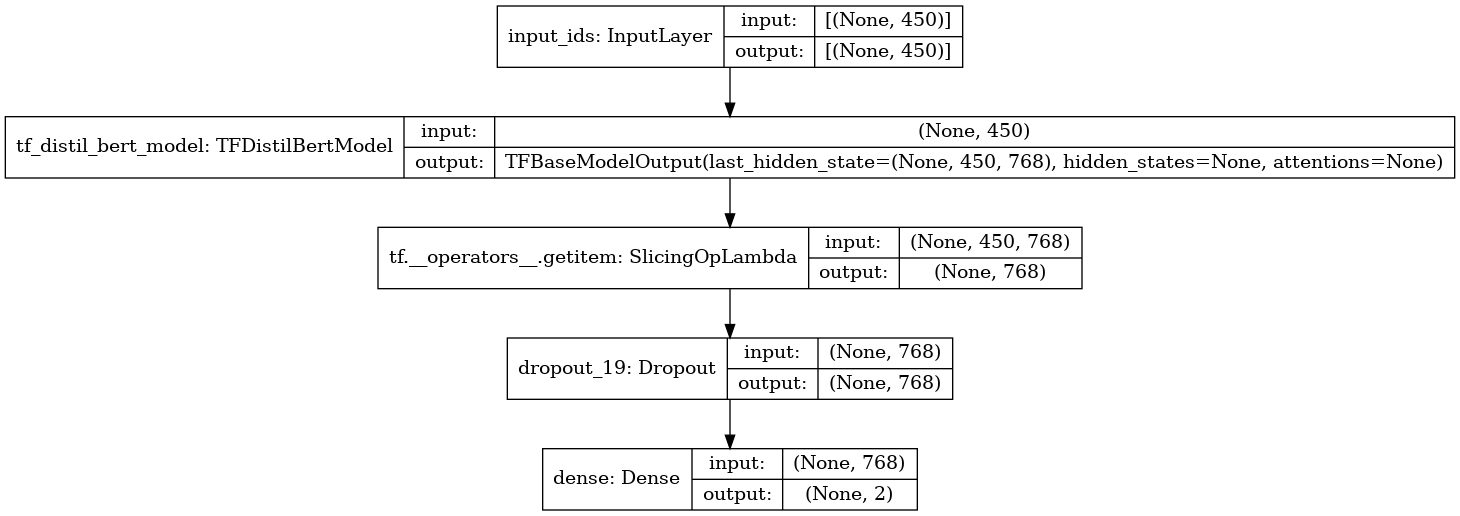

In [31]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [32]:
BATCH_SIZE = 32*strategy.num_replicas_in_sync #activated if using kaggle TPU

In [33]:
n_steps = X_train_encoded.shape[0] // BATCH_SIZE
train_history = model.fit(
     x = {'input_ids':X_train_encoded}, y = y_train_encoded,
    steps_per_epoch=n_steps,
    epochs=15
)

Epoch 1/15
221/221 [==============================] - 120s 347ms/step - loss: 0.2097 - accuracy: 0.9007
Epoch 2/15
221/221 [==============================] - 50s 224ms/step - loss: 0.0141 - accuracy: 0.9951
Epoch 3/15
221/221 [==============================] - 50s 224ms/step - loss: 0.0068 - accuracy: 0.9979
Epoch 4/15
221/221 [==============================] - 50s 224ms/step - loss: 0.0035 - accuracy: 0.9989
Epoch 5/15
221/221 [==============================] - 50s 225ms/step - loss: 0.0026 - accuracy: 0.9992
Epoch 6/15
221/221 [==============================] - 50s 224ms/step - loss: 0.0011 - accuracy: 0.9997
Epoch 7/15
221/221 [==============================] - 50s 225ms/step - loss: 0.0049 - accuracy: 0.9983
Epoch 8/15
221/221 [==============================] - 50s 225ms/step - loss: 0.0012 - accuracy: 0.9998
Epoch 9/15
221/221 [==============================] - 50s 224ms/step - loss: 0.0015 - accuracy: 0.9996
Epoch 10/15
221/221 [==============================] - 50s 224ms/step - 

Code taken from google BERT text classification https://www.tensorflow.org/text/tutorials/classify_text_with_bert

dict_keys(['loss', 'accuracy'])


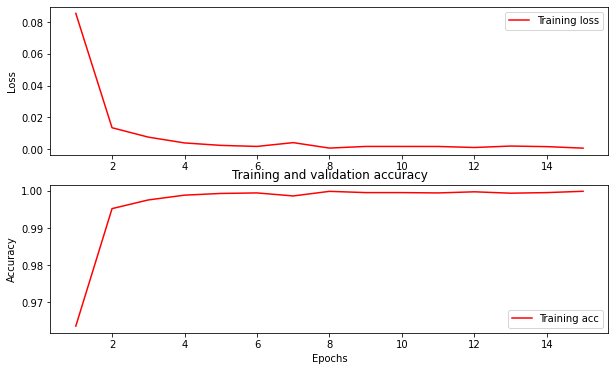

In [34]:
history_dict = train_history.history
print(history_dict.keys())

acc = history_dict['accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [35]:
prediction_DistilBERT = model.predict({'input_ids':X_test_encoded},verbose = 1)

prediction_DB = np.argmax(prediction_DistilBERT, axis = 1)

443/443 [==============================] - 19s 37ms/step


In [36]:
result_DistilBERT_df = pd.DataFrame({'text':X_test,'Correct_news':y_test, 'Predicted_news':prediction_DB})
result_DistilBERT_df.head(10)

,text,Correct_news,Predicted_news
20549,south korea's president says will continue pha...,0,0
36772,boom! judge napolitano: the only crime committ...,1,1
24812,trump fights release of video testimony in fra...,0,0
53955,international air ban over iraqi kurdistan com...,0,0
1278,democratic u.s. senator questions deutsche ban...,0,0
6774,trump not now considering value-added tax or c...,0,0
46258,"trump uses policy speech to attack media, prom...",0,0
71291,atf permanently relocating more agents to viol...,0,0
49848,senators concerned icahn is influencing regula...,0,0
45081,socialismo ou barbárie enviar para um amigo no...,1,1


In [37]:
print("Accuracy :",accuracy_score(result_DistilBERT_df.Correct_news, result_DistilBERT_df.Predicted_news))
print(classification_report(result_DistilBERT_df.Correct_news, result_DistilBERT_df.Predicted_news))

Accuracy : 0.9963276836158192
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7005
           1       1.00      1.00      1.00      7155

    accuracy                           1.00     14160
   macro avg       1.00      1.00      1.00     14160
weighted avg       1.00      1.00      1.00     14160



Look at where the model mismatched

In [38]:
df_DistilBERT_fn = result_DistilBERT_df[(result_DistilBERT_df['Correct_news'] == 0) & (result_DistilBERT_df['Predicted_news'] == 1)]
df_DistilBERT_fp = result_DistilBERT_df[(result_DistilBERT_df['Correct_news'] == 1) & (result_DistilBERT_df['Predicted_news'] == 0)]

In [39]:
df_DistilBERT_fn.head(10)

,text,Correct_news,Predicted_news
11069,"as his campaign crumbles, trump is spending hi...",0,1
10909,watch: donald trump is showing a side of the g...,0,1
50931,the plight of the bitter nerd: why so many awk...,0,1
48669,donald and billy on the bus\r\n its billy bush...,0,1
69321,exclusive: kentucky clerk: 'this is a fight wo...,0,1
17826,rush limbaugh: left has 'fear and hatred of ch...,0,1
22333,"welcome to trump county, u.s.a. it is a little...",0,1
4889,dear gop: hire me and i’ll give you the debate...,0,1
16724,"macedonia's parliament adopts 2018 budget, opp...",0,1
63384,donald trump and the $12.7 million ukraine con...,0,1


In [40]:
if not df_DistilBERT_fn.empty:
    print(df_DistilBERT_fn.text.iloc[0])

as his campaign crumbles, trump is spending his day fighting with msnbc's joe scarborough donald trump’s presidential campaign is literally losing red states by the day, so what is the republican presidential nominee doing? he is sending angry tweets to msnbc’s joe scarborough.

instead of dealing with the fact that his campaign is literally burning to the ground, donald trump is once again planted in front of his tv obsessing over his media coverage.

in case anybody thought that trump’s tweet at scarborough was one-off today, the republican nominee also attacked cnn’s don lemon:

a day after threatening the life of his democratic opponent, donald trump isn’t trying to fix his campaign. instead, trump is whining about the media and his coverage.

trump exists in his own universe. the presidential campaign is a distant second in his mind to his endless cravings for positive attention and publicity. hillary clinton is making a play for the deep red state of utah, while donald trump is b

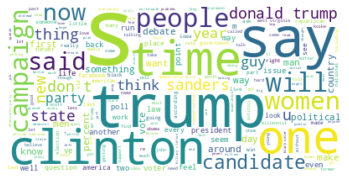

In [41]:
text = " ".join(text for text in df_DistilBERT_fn.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)


plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [42]:
df_DistilBERT_fp.head(10)

,text,Correct_news,Predicted_news
10058,"thanks to trump, ‘local milk people’ is trend...",1,0
856,michael moore wants a spot in hillary’s cabine...,1,0
38688,trump’s economic program set for rough reality...,1,0
24633,just another day in the life of the clinton cr...,1,0
2906,islamophobia must be fought and defeated when ...,1,0
21878,best description ever of liberalism in one par...,1,0
65824,"boom! ted cruz, desantis push for term limits:...",1,0
46956,what would happen if the u.s. was nuked? ever ...,1,0
16419,just another day in the life of the clinton cr...,1,0
33279,was martin luther king jr. a republican? the ...,1,0


In [43]:
if not df_DistilBERT_fp.empty:
    df_DistilBERT_fp.text.iloc[0]

## Testing DistilBERT using mask layer
We are creating a model very alike the last one. However, instead of one input to the transfomer, we have two.

Also, we are extending the model to one more dense layer

In [44]:
X_train_encoded = tokenizer.batch_encode_plus(X_train, return_token_type_ids=False, return_attention_mask=True,
        max_length=450, return_tensors = 'tf', padding=True, truncation=True)
X_test_encoded = tokenizer.batch_encode_plus(X_test, return_token_type_ids=False, return_attention_mask=True,
        max_length=450, return_tensors = 'tf', padding=True, truncation=True)

y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=2,dtype = 'int32')
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=2,dtype = 'int32')

In [45]:
X_train_encoded_ids = np.array(X_train_encoded['input_ids'])
X_test_encoded_ids = np.array(X_test_encoded['input_ids'])
X_train_encoded_ids_mask = np.array(X_train_encoded['attention_mask'])
X_test_encoded_ids_mask = np.array(X_test_encoded['attention_mask'])

Like in the other model, it was inspired by https://www.kaggle.com/code/foolofatook/news-classification-using-bert/notebook
Modified to work with binary classification and input mas

In [46]:
 def build_bert_model_mask(transformer, length):
    input_ids = tf.keras.layers.Input(shape=(length,), dtype=tf.int32, name="input_ids")
    input_mask = tf.keras.layers.Input(shape = (length,), dtype = tf.int32, name = 'input_mask')
    embedding = transformer([input_ids,input_mask])[0]
    cls_token = embedding[:, 0, :]
    out = tf.keras.layers.Dropout(0.1)(cls_token)
    y = tf.keras.layers.Dense(2,activation = 'sigmoid')(out)
    model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
    model.layers[2].trainable = True
    model.compile(tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon = 1e-7), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    return model

In [47]:
with strategy.scope():
    transformerModel = transformers.TFAutoModel.from_pretrained('distilbert-base-uncased')
    model = build_bert_model_mask(transformerModel,450 )

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


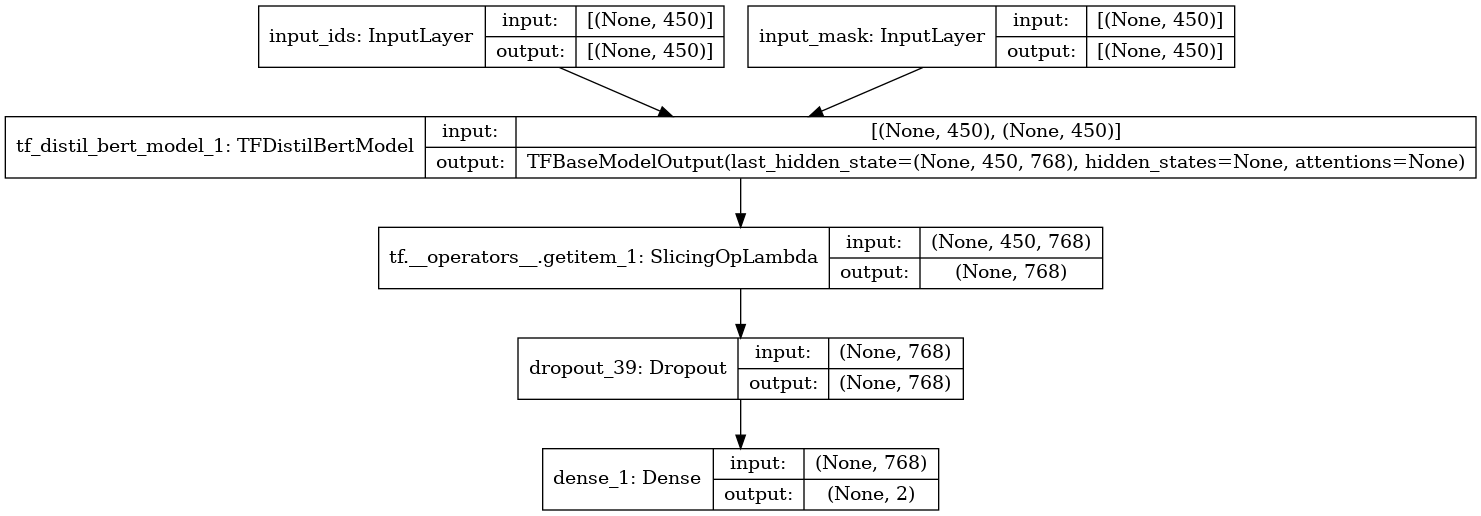

In [48]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [49]:
n_steps = X_train_encoded_ids.shape[0] // BATCH_SIZE
train_history = model.fit(
    x = {'input_ids':X_train_encoded_ids,'input_mask':X_train_encoded_ids_mask}, y = y_train_encoded,
    steps_per_epoch=n_steps,
    epochs=15
)

Epoch 1/15
221/221 [==============================] - 122s 347ms/step - loss: 0.1903 - accuracy: 0.9095
Epoch 2/15
221/221 [==============================] - 50s 225ms/step - loss: 0.0141 - accuracy: 0.9945
Epoch 3/15
221/221 [==============================] - 50s 225ms/step - loss: 0.0055 - accuracy: 0.9984
Epoch 4/15
221/221 [==============================] - 50s 225ms/step - loss: 0.0020 - accuracy: 0.9993
Epoch 5/15
221/221 [==============================] - 50s 225ms/step - loss: 0.0037 - accuracy: 0.9988
Epoch 6/15
221/221 [==============================] - 50s 225ms/step - loss: 0.0020 - accuracy: 0.9994
Epoch 7/15
221/221 [==============================] - 50s 225ms/step - loss: 3.8552e-04 - accuracy: 0.9999
Epoch 8/15
221/221 [==============================] - 50s 225ms/step - loss: 0.0017 - accuracy: 0.9995
Epoch 9/15
221/221 [==============================] - 50s 225ms/step - loss: 0.0014 - accuracy: 0.9996
Epoch 10/15
221/221 [==============================] - 50s 225ms/ste

dict_keys(['loss', 'accuracy'])


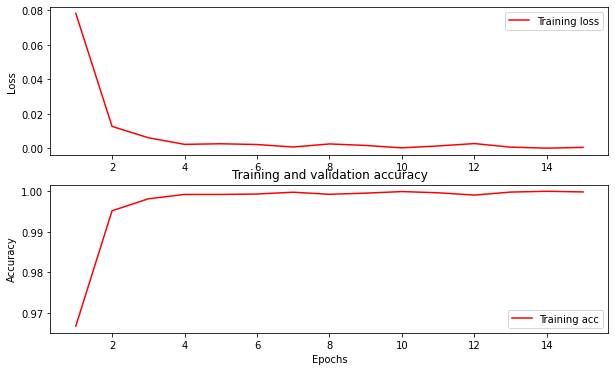

In [50]:
history_dict = train_history.history
print(history_dict.keys())

acc = history_dict['accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [51]:
prediction_DistilBERTMask = model.predict({'input_ids':X_test_encoded_ids,'input_mask':X_test_encoded_ids_mask})
prediction_DBM = np.argmax(prediction_DistilBERTMask, axis = 1)

In [52]:
result_DBM_df = pd.DataFrame({'text':X_test,'Correct_news':y_test, 'Predicted_news':prediction_DBM})
result_DBM_df.head(10)

,text,Correct_news,Predicted_news
20549,south korea's president says will continue pha...,0,0
36772,boom! judge napolitano: the only crime committ...,1,1
24812,trump fights release of video testimony in fra...,0,0
53955,international air ban over iraqi kurdistan com...,0,0
1278,democratic u.s. senator questions deutsche ban...,0,0
6774,trump not now considering value-added tax or c...,0,0
46258,"trump uses policy speech to attack media, prom...",0,0
71291,atf permanently relocating more agents to viol...,0,0
49848,senators concerned icahn is influencing regula...,0,0
45081,socialismo ou barbárie enviar para um amigo no...,1,1


In [53]:
print("Accuracy :",accuracy_score(result_DBM_df.Correct_news, result_DBM_df.Predicted_news))
print(classification_report(result_DBM_df.Correct_news, result_DBM_df.Predicted_news))

Accuracy : 0.9927966101694915
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7005
           1       1.00      0.99      0.99      7155

    accuracy                           0.99     14160
   macro avg       0.99      0.99      0.99     14160
weighted avg       0.99      0.99      0.99     14160



In [54]:
df_DBM_fn = result_DBM_df[(result_DBM_df['Correct_news'] == 0) & (result_DBM_df['Predicted_news'] == 1)]
df_DBM_fp = result_DBM_df[(result_DBM_df['Correct_news'] == 1) & (result_DBM_df['Predicted_news'] == 0)]

In [55]:
df_DBM_fn.head(10)

,text,Correct_news,Predicted_news
48669,donald and billy on the bus\r\n its billy bush...,0,1
22952,california’s first dog passes away - breitbart...,0,1
49348,"spanish pm, in catalonia, calls for big turnou...",0,1
47000,trump called it months ago: anthony weiner thr...,0,1
9218,gas prices could drop toward $1 a gallon in so...,0,1
48963,the adoration of kim jong un pyongyang - north...,0,1
17721,factbox: what do laws say about catalan self-d...,0,1
25644,"black millennials: don’t help donald trump ok,...",0,1
38605,run or wait? tokyo's koike faces dilemma ahead...,0,1


In [56]:
if not df_DBM_fn.empty:
    print(df_DBM_fn.text.iloc[0])


donald and billy on the bus
 its billy bushs snickering that really gets to me. in the video from 2005, published friday by the washington post, you can hear mr. bush (first cousin to george w.) wheezing ecstatically as donald j. trump brags, inadvertently into a hot mic, about sexually harassing and groping women. the pair, along with a passel of unidentified men, are on a bus en route to film an access hollywood segment with the actress arianne zucker.

through the window of the bus, mr. bush seems to spot ms. zucker first, as she waits to greet them. sheesh, he blurts, breathless, telling mr. trump how hot your girl is. you can feel mr. bushs giddiness, a contact high, at getting to join a more powerful man in the oldest and most sacred of male bonding exercises: objectifying women.

mr. trump spies ms. zucker too. whoa!

yes! mr. bush grunts, beavis-esque, yes, the donald has scored!

of course, the donald has not scored. the donald is on the nbc lot to shoot a guest appearance on 

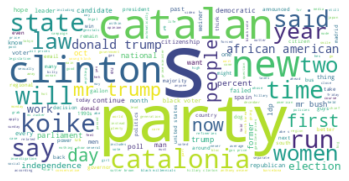

In [57]:
text = " ".join(text for text in df_DBM_fn.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [58]:
df_DBM_fp.head(10)

,text,Correct_news,Predicted_news
29326,clinton investigation re-opened due to emails ...,1,0
856,michael moore wants a spot in hillary’s cabine...,1,0
67535,cambodia – a thorny path to elections | new ea...,1,0
38688,trump’s economic program set for rough reality...,1,0
24633,just another day in the life of the clinton cr...,1,0
16789,george soros funds anti-trump riots similarly ...,1,0
63146,hollywood darling sandra bullock to play “abor...,1,0
59670,actor mark ruffalo returns from standing rock ...,1,0
8643,deterioration of interracial relations during ...,1,0
6424,we told you so! the zika virus is harmless in ...,1,0


In [59]:
if not df_DBM_fp.empty: 
    print(df_DBM_fp.text.iloc[0])

clinton investigation re-opened due to emails uncovered in weiner sexting case 
during an investigation into former new york congressman anthony weiner’s lewd texting with an underage girl, new communications were uncovered on the congressman’s computer which have given fbi director james comey cause to re-open the investigation into hillary clinton’s handling of classified information.
on friday, comey notified the leaders of the congressional oversight committees that the investigation has been re-opened. in his letter, he wrote:
in connection with an unrelated case, the fbi has learned of the existence of emails that appear to be pertinent to the investigation. i am writing to inform you that the investigative team briefed me on this yesterday, and i agreed that the fbi should take appropriate investigative steps designed to allow investigators to review these emails to determine whether they contain classified information, as well as to assess their importance to our investigation.

## Confusion matrix of Logistic regression, DistilBERT and DistilBERT with attention mask

### Logistic regression

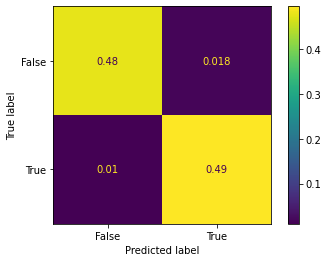

In [60]:
cm = confusion_matrix(y_test, prediction_LR, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['False','True'])
cmd.plot()

### DistilBERT

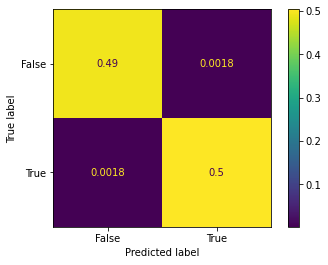

In [61]:
cm = confusion_matrix(y_test, prediction_DB, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['False','True'])
cmd.plot()

### DistilBERT with attention mask

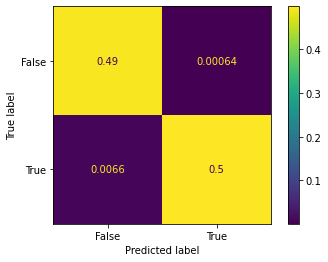

In [62]:
cm = confusion_matrix(y_test, prediction_DBM, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['False','True'])
cmd.plot()